<h1><center>Kaggle: Catch me if you can<center></h1>

* автор: БилибинС.К.
* telegram: @serg_bill
    
#### Цель:

проанализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

#### Данные:

|site1|time1|site2|time2|site3|time3|site4|time4|site5|time5|site6|time6|site7|time7|site8|time8|site9|time9|site10|time10|target|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|56|2013-01-12 08:05:57|55.0|2013-01-12 08:05:57|nan|NaT|nan|NaT|nan|NaT|nan|NaT|nan|NaT|nan|NaT|nan|NaT|nan|NaT|0|
|56|2013-01-12 08:37:23|55.0|2013-01-12 08:37:23|56.0|2013-01-12 09:07:07|55.0|2013-01-12 09:07:09|nan|NaT|nan|NaT|nan|NaT|nan|NaT|nan|NaT|nan|NaT|0|
|946|2013-01-12 08:50:13|946.0|2013-01-12 08:50:14|951.0|2013-01-12 08:50:15|946.0|2013-01-12 08:50:15|946.0|2013-01-12 08:50:16|945.0|2013-01-12 08:50:16|948.0|2013-01-12 08:50:16|784.0|2013-01-12 08:50:16|949.0|2013-01-12 08:50:17|946.0|2013-01-12 08:50:17|0|
|945|2013-01-12 08:50:17|948.0|2013-01-12 08:50:17|949.0|2013-01-12 08:50:18|948.0|2013-01-12 08:50:18|945.0|2013-01-12 08:50:18|946.0|2013-01-12 08:50:18|947.0|2013-01-12 08:50:19|945.0|2013-01-12 08:50:19|946.0|2013-01-12 08:50:19|946.0|2013-01-12 08:50:20|0|
|947|2013-01-12 08:50:20|950.0|2013-01-12 08:50:20|948.0|2013-01-12 08:50:20|947.0|2013-01-12 08:50:21|950.0|2013-01-12 08:50:21|952.0|2013-01-12 08:50:21|946.0|2013-01-12 08:50:21|951.0|2013-01-12 08:50:22|946.0|2013-01-12 08:50:22|947.0|2013-01-12 08:50:22|0|
    
#### Содержание:

* загрузка данных
* сайты из трейн и тест частей
* выбор схемы валидации и размера отложнной выборки
* кодирование сайтов с помощью tfidf (оптимизация ngram_range)
* временные признаки: день года, неделя года, год, месяц, день, день недели, час 
* отбор признаков
* оптимизация гиперпараметров
* стекинг

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pickle
from collections import defaultdict
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit,\
                                    cross_val_score, cross_validate
import scipy.stats as stats
from sklearn.metrics import roc_auc_score
import gc
import warnings
warnings.filterwarnings('ignore')
import os
import category_encoders as ce
from tqdm import tqdm_notebook
import json
from itertools import combinations, groupby
from functools import reduce
from sklearn.cluster import KMeans
import time
from itertools import groupby
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import pandas as pd
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split
from matplotlib_venn import venn2, venn3, venn3_circles
from scipy.sparse import hstack, vstack, csc_matrix
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import svm

In [76]:
def _get_val_holdout_scores(estimator, X, y, holdout_share, cv, metric, stratify):  
    
    '''
    Считает метрику на валидационной и на отложенной выборках
    
    Параметры:
        1) estimator - модель
        2) X - признаки
        3) y - таргет
        4) holdout_share - доля отложенной части
        5) cv - схема валидации
        6) metric - метрика
        7) stratify - стратификация таргета (-да, -нет)
    '''
            
    if stratify:
        X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(X, y, test_size = holdout_share, stratify = y)
    else:
        X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(X, y, test_size = holdout_share) 
    scores = cross_validate(estimator, X_TR, Y_TR, cv = cv, scoring = metric)['test_score']    
    mean_cv = scores.mean()   
    
    estimator.fit(X_TR, Y_TR)
    Y_PRED = estimator.predict(X_HOLDOUT)    
    Y_PREDPROB = estimator.predict_proba(X_HOLDOUT)[:, 1] 
    if metric == 'roc_auc':
        holdout = roc_auc_score(Y_HOLDOUT, Y_PREDPROB)
    if metric == 'accuracy':
        holdout = accuracy_score(Y_HOLDOUT, Y_PRED)
    if metric == 'precision':
        holdout = precision_score(Y_HOLDOUT, Y_PRED)
    if metric == 'recall':
        holdout = recall_score(Y_HOLDOUT, Y_PRED)
    if metric == 'f1':
        holdout = f1_score(Y_HOLDOUT, Y_PRED)   
        
    return (mean_cv, holdout, scores.max() - scores.min())

class FEATURE_SELECTOR():
    
    def __init__(self, estimator, cv, scoring, holdout_share, stratify, seed):
        self.est = estimator
        self.cv = cv
        self.scoring = scoring
        self.holdout_share = holdout_share
        self.stratify = stratify
        self.seed = seed
        
    def fit(self, X, y):        
        if self.stratify:
            # разбиваем данные на трейн и отложенную части, сохраняя пропорции таргета
            X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(X, y, stratify = y,\
                                                                test_size = self.holdout_share,\
                                                                random_state = self.seed, shuffle = True)
        else:
            X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(X, y, test_size = self.holdout_share)
            
        self.X_TR, self.X_HOLDOUT, self.Y_TR, self.Y_HOLDOUT = X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT

        # считаем валидацию каждого признака
        scores = []
        for i in tqdm_notebook(range(X_TR.shape[1])):
            mean_cv = cross_validate(self.est, X_TR[:, i].reshape(-1,1), Y_TR,\
                                     cv = self.cv, scoring = self.scoring)['test_score'].mean()
            scores.append(mean_cv)
        self.order = np.argsort(scores)[::-1]
        return scores
    
    def select_features(self, early_stopping):
        
        ############################################################################################################
        def _get_val_holdout_scores(estimator, _X_TR, _X_HOLDOUT, _Y_TR, _Y_HOLDOUT, cv, metric):
            mean_cv = cross_validate(estimator, _X_TR, _Y_TR, cv = cv, scoring = metric)['test_score'].mean()
            estimator.fit(_X_TR, _Y_TR)
            _Y_PREDPROB = estimator.predict_proba(_X_HOLDOUT)[:, 1]
            _Y_PRED = estimator.predict(_X_HOLDOUT)
            if metric == 'roc_auc':
                holdout = roc_auc_score(_Y_HOLDOUT, _Y_PREDPROB)
            if metric == 'accuracy':
                holdout = accuracy_score(_Y_HOLDOUT, _Y_PRED)
            if metric == 'precision':
                holdout = precision_score(_Y_HOLDOUT, _Y_PRED)
            if metric == 'recall':
                holdout = recall_score(_Y_HOLDOUT, _Y_PRED)
            if metric == 'f1':
                holdout = f1_score(_Y_HOLDOUT, _Y_PRED)
            return (mean_cv, holdout)
        #################################################################################################################
        
        # лучший набор, лучшая валидация, лучшая отложенная
        # бесполезные признаки до и после повторного отбора 
        best_features, best_cv, best_holdout, to_drop_before, to_drop_after = [], .5, .5, [], []
        counter = 0
        # по признакам в порядке убывания валидации
        for i in tqdm_notebook(self.order):

            # добавляем к писку лучших
            current_features = best_features+[i]

            # валидация, отложенная
            mean_cv, holdout = _get_val_holdout_scores(self.est, self.X_TR[:, current_features],\
                                                       self.X_HOLDOUT[:, current_features],\
                                                       self.Y_TR, self.Y_HOLDOUT, cv=self.cv, metric=self.scoring)

            # если оба скора растут
            if (mean_cv>best_cv) & (holdout>best_holdout):
                # обновляем лучшие скоры, лучшие признаки, счетчик ранней остановки
                best_cv = mean_cv
                best_holdout = holdout
                best_features = current_features
                counter = 0
            else:
                # если скоры не растут, добавляем признак в претенденты на удаление
                to_drop_before.append(i)

                # обновляем счетчик ранней остановки
                counter+=1

                # останавливаем отбор признаков, если метрика не улучшается early_stopping итераций подряд
                if counter == early_stopping:
                    break

        # пока списки кандидатов на удаление ДО и ПОСЛЕ отбора не перестанут изменяться
        counter = 0
        while True:   

            # добавляем очередной признак
            for i in tqdm_notebook(to_drop_before):
                current_features = best_features+[i]

                # валидация, отложенная
                mean_cv, holdout = _get_val_holdout_scores(self.est, self.X_TR[:, current_features],\
                                                       self.X_HOLDOUT[:, current_features],\
                                                       self.Y_TR, self.Y_HOLDOUT, cv=self.cv, metric=self.scoring)

                if (mean_cv>best_cv) & (holdout>best_holdout):
                    best_cv = mean_cv
                    best_holdout = holdout
                    best_features = current_features
                    counter = 0
                else:
                    # выбрасываем, если он не дал улучшений
                    to_drop_after.append(i)
                    if counter == early_stopping:
                        break

            # если списки признаков до и после отбора не изменились, прекращаем отбор
            if len(to_drop_before) == len(to_drop_after):
                break
            else:
                # список до --> список после, список после - пустой
                to_drop_before = to_drop_after
                to_drop_after = []  
                
        return (best_cv, best_holdout, best_features)
    
def _do_stacking(X_tr, y_tr, X_te, stratify, holdout_share, seed, n_iterations):
    
    '''
    Делает стекинг моделей
    
    Псевдокод:
        1) разбиваем трейн на трейн и отложенную части
        2) делаем n_iterations операций стекинга:
            2.1) генерируем алгоритмы(каждый алгоритм инициализируем случайными гиперпараметрами): 
                    -LogisticRegression
                    -Lightgbm
                    -Xgboost
                    -SVM
                    -RandomForest
            2.2) делаем подвыборку признаков, которые будут участовать в обучении на текущей итерации
            2.3) выбираем число фолдов (случайным образом), по которым будет производиться стекинг на текущей итерации
            2.4) делаем предсказания для трейна, отложенной, теста --> метапризнаки
            2.5) генерируем взаимодействия пар метапризнаков (*, /, -, +)
        3) считаем метрику на отложенной части для каждого метапризнака
        4) жадным способом находим лучший набор признаков
        5) объединяем трейн и валидацию --> получаем полный трейн датасет
    Вывод:
        (метапризнаки трейн, метапризнаки тест, лучший скор на отложенной части)
    '''
    
    ###################################################################################################
    def _get_oof(clf, nfolds, x_train, x_holdout, y_train, x_test, seed):
        ''' Делает предсказания на валидации, отложенной, тесте'''
        oof_train = np.zeros((x_train.shape[0],))
        oof_test = np.zeros((x_test.shape[0],))
        oof_holdout = np.zeros((x_holdout.shape[0],))

        oof_test_skf = np.empty((nfolds, x_test.shape[0]))
        oof_holdout_skf = np.empty((nfolds, x_holdout.shape[0]))

        for i, (train_index, val_index) in enumerate(KFold(nfolds, random_state = seed)):
            x_tr = x_train[train_index]
            y_tr = y_train[train_index]
            x_val = x_train[val_index]

            clf.fit(x_tr, y_tr)        

            oof_train[test_index] = clf.predict_proba(x_val)[:, 1]
            oof_test_skf[i, :] = clf.predict_proba(x_test)[:, 1]
            oof_holdout_skf[i, :] = clf.predict_proba(x_holdout)[:, 1]

        oof_test[:] = oof_test_skf.mean(axis=0)
        oof_holdout[:] = oof_holdout_skf.mean(axis=0)

        return (oof_train.reshape(-1, 1), oof_holdout.reshape(-1, 1), oof_test.reshape(-1, 1))
    ##########################################################################################################
    
    # трейн, отложенная части
    if stratify:
        # разбиваем данные на трейн и отложенную части, сохраняя пропорции таргета
        X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(X_tr, y_tr, stratify = y_tr,\
                                                                    test_size = holdout_share,\
                                                                    random_state = seed, shuffle = True)
    else:
        X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(X_tr, y_tr, test_size = holdout_share)    
    

    # число итераций стекинга
    n_iterations = n_iterations

    # кол-во признаков
    n_features = X_TR.shape[1]

    # метапризнаки
    _X_metas_tr = []
    _X_metas_holdout = []
    _X_metas_te = []

    # делаем n_iterations итераций стекинга
    for seed in range(n_iterations):

        # фиксируем генератор случайных чисел
        np.random.seed(seed)

        # генерируем число фолдов
        nfolds = np.random.uniform(3, 100)

        # выбираем признаки, которые будут использоваться
        subsample = np.random.uniform(.5, 1)
        N = np.int32(np.around(subsample*n_features))
        feat_idxs = np.random.choice(range(n_features), N)
        
        # генерируем модели
        logit_est = LogisticRegression(random_state = seed, C = np.random.choice(np.logspace(1, 3, 1000)))
        lgb_est = LGBMClassifier(random_state = seed,
                                 n_estimators = np.int32(np.random.uniform(100, 1000)),\
                                 max_depth = np.int32(np.random.uniform(3, 120)),\
                                 num_leaves = np.int32(np.uniform(8, 512)),\
                                 subsample = np.random.uniform(.3, 1),\
                                 colsample_bytree = np.random.uniform(.3, 1),\
                                 min_child_samples = np.int32(np.random.chopice(20, 200)),\      
                                 learning_rate = np.random.uniform(.05, .1))
        xgb_est = xgb.XGBClassifier(random_state = seed, n_estimators = np.int32(np.random.uniform(100, 1000)),\
                                    max_depth = np.int32(np.random.uniform(3, 12)),\
                                    subsample = np.random.uniform(.3, 1),
                                    colsample_bytree = np.random.uniform(.3, 1),\
                                    min_child_weight = np.int32(np.random.uniform(1, 15),\
                                    learning_rate = np.random.uniform(.05, .1)))

        rf_est = RandomForestClassifier(random_state = seed, n_estimators = np.int32(np.random.uniform(100, 1000)),\
                                       max_depth = np.int32(np.random.uniform(2, 12)),\
                                       min_samples_split = np.int32(np.random.uniform(1, 50)))

        svm_est = svm.SVC(C = np.random.uniform(0, 10),\
            kernel = np.random.choice(['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']))

        # делаем предсказания на валидцаии, отложенной,тесте
        logit_oof_train, logit_oof_holdout, logit_oof_test = _get_oof(logit_est, nfolds,\
                                                   X_TR[:, feat_idxs], X_HOLDOUT[:, feat_idxs],\
                                                   Y_TR, X_te[:, feat_idxs], seed) 
        lgb_oof_train, lgb_oof_holdout, lgb_oof_test = _get_oof(lgb_est, nfolds,\
                                               X_TR[:, feat_idxs], X_HOLDOUT[:, feat_idxs],\
                                               Y_TR, X_te[:, feat_idxs], seed) 

        svm_oof_train, svm_oof_holdout, svm_oof_test = _get_oof(svm_est, nfolds,\
                                               X_TR[:, feat_idxs], X_HOLDOUT[:, feat_idxs],\
                                               Y_TR, X_te[:, feat_idxs], seed)

        rf_oof_train, rf_oof_holdout, rf_oof_test = _get_oof(rf_est, nfolds,\
                                               X_TR[:, feat_idxs], X_HOLDOUT[:, feat_idxs],\
                                               Y_TR, X_te[:, feat_idxs], seed)

        # собиарем метапризнаки для трейна, отложенной, теста
        _X_metas_tr.append(np.concatenate((logit_oof_train, lgb_oof_train, svm_oof_train, rf_oof_train), axis=1))  
        _X_metas_holdout.append(np.concatenate((logit_oof_holdout, lgb_oof_holdout, svm_oof_holdout, rf_oof_holdout), axis=1))  
        _X_metas_te.append(np.concatenate((logit_oof_test, lgb_oof_test, svm_oof_test, rf_oof_test), axis=1))

    # метапризнаки трейн, отложенная, тест
    X_meta_tr = np.column_stack(_X_metas_tr)   
    X_meta_holdout = np.column_stack(_X_metas_holdout)
    X_meta_te = np.column_stack(_X_metas_te)  
    
    # генерируем взаимодействия метапризнаков    
    L_tr, L_holdout, L_te = [], [], []
    
    # выбираем кононку
    for i in range(X_meta_tr.shape[1]):
        
        # проходим по оставшиимся колонкам
        for j in range(i+1, X_meta_tr.shape[1]):
            
            # выбираем пару признаков
            x1_tr, x2_tr = X_meta_tr[:, i], X_meta_tr[:, j]
            x1_holdout, x2_holdout = X_meta_holdout[:, i], X_meta_holdout[:, j]
            x1_te, x2_te = X_meta_te[:, i], X_meta_te[:, j]
            
            # считаем взаимодействия
            L_tr.append(x1_tr*x2_tr)
            L_tr.append(x1_tr/x2_tr)
            L_tr.append(x1_tr-x2_tr)
            L_tr.append(x1_tr+x2_tr)
            
            L_holdout.append(x1_holdout*x2_holdout)
            L_holdout.append(x1_holdout/x2_holdout)
            L_holdout.append(x1_holdout-x2_holdout)
            L_holdout.append(x1_holdout+x2_holdout)
            
            L_te.append(x1_te*x2_te)
            L_te.append(x1_te/x2_te)
            L_te.append(x1_te-x2_te)
            L_te.append(x1_te+x2_te)
            
    # финальные метапризнаки
    X_meta_interactions_tr = np.column_stack(L_tr)            
    X_meta_interactions_holdout = np.column_stack(L_holdout)            
    X_meta_interactions_te = np.column_stack(L_te)  
    
    # собираем метрики на отложенной части для каждого признака
    scores = []
    lgb_meta = LGBMClassifier(random_state = seed)
    for i in tqdm_notebook(X_meta_interactions_tr.shape[1]):
        _x_tr = X_meta_interactions_tr[:, i].reshape(-1, 1)
        _x_holdout = X_meta_interactions_holdout[:, i].reshape(-1, 1)
        lgb_meta.fit(_x_tr, Y_TR)
        _y_predprob = lgb_meta.predict_proba(_x_holdout)[:, 1]
        scores.append(roc_auc_score(Y_HOLDOUT, _y_predprob))
    
    # сортируем признаки в порядке убывания метрики
    order = np.argsort(scores)[::-1]
    
    best_score, best_features, drop_features = .5, [], []
    for i in tqdm_notebook(order):
        
        # добавляем признак
        current_features = best_features + [i]
        _X_tr = X_meta_interactions_tr[: current_features]
        _X_holdout = X_meta_interactions_holdout[: current_features]
        _X_te = X_meta_interactions_te[: current_features]
        
        # считаем метрику
        lgb_meta.fit(_X_tr, Y_TR)
        _y_predprob = lgb_meta.predict_proba(_X_holdout)[:, 1]
        new_score = roc_auc_score(Y_HOLDOUT, _y_predprob)
        
        # если метрика на отложенной части растет
        if new_score>best_score:
            # обновляем лучшие характеристики
            best_score = new_score
            best_X_tr = _X_tr
            best_X_holdout = _X_holdout
            best_X_te = _X_te
        # если нет
        else:
            # добавляем признак в повторную проверку
            drop_features.append(i)
            
    # пока списки кандидатов на удаление ДО и ПОСЛЕ отбора не перестанут изменяться
    to_drop_before = drop_features
    to_drop_after = []
    while True:   

        for i in tqdm_notebook(to_drop_before):
        
        # добавляем признак
        current_features = best_features + [i]
        _X_tr = X_meta_interactions_tr[: current_features]
        _X_holdout = X_meta_interactions_holdout[: current_features]
        _X_te = X_meta_interactions_te[: current_features]
        
        # считаем метрику
        lgb_meta.fit(_X_tr, Y_TR)
        _y_predprob = lgb_meta.predict_proba(_X_holdout)[:, 1]
        new_score = roc_auc_score(Y_HOLDOUT, _y_predprob)
        
        
        if new_score>best_score:
            
            # обновляем лучшие характеристики
            best_score = new_score
            best_X_tr = _X_tr
            best_X_holdout = _X_holdout
            best_X_te = _X_te
        else:
            
            # добавляем признак в повторную проверку
            to_drop_after.append(i)
            
        # если списки ДО и ПОСЛЕ одинаковые --> прекращаем отбор
        if len(to_drop_before) == len(to_drop_after):
            break
        # если нет --> продолжаем отбор
        else:            
            to_drop_before = to_drop_after
            to_drop_after = []
            
    # финальные метапризнаки 
    X_best_tr = np.concatenate((best_X_tr, best_X_holdout), axis = 0)
    X_best_te = best_X_te 
    
    return (best_score, X_best_tr, X_best_te)

In [3]:
times = ['time%d' % i for i in range(1, 11)]
sites = ['site%d' % i for i in range(1, 11)]
SEED = 13

df_tr = pd.read_csv('train_sessions.csv', parse_dates = times).set_index('session_id').sort_values('time1')
df_te = pd.read_csv('test_sessions.csv', parse_dates = times).set_index('session_id')
y_tr = df_tr['target']

In [4]:
unique_sites_tr = pd.Series(df_tr[sites].values.flatten()).dropna().unique()
unique_sites_te = pd.Series(df_te[sites].values.flatten()).dropna().unique()

In [6]:
_sites_report_df = pd.DataFrame()
for site_tr in tqdm_notebook(unique_sites_tr):
    _sites_report_df.loc[site_tr, 'трейн'] = True
for site_te in tqdm_notebook(unique_sites_te):
    _sites_report_df.loc[site_te, 'тест'] = True
_sites_report_df.fillna(False, inplace = True)  
_sites_report_df.index.name = 'сайт'

### сайты в трейне и тесте

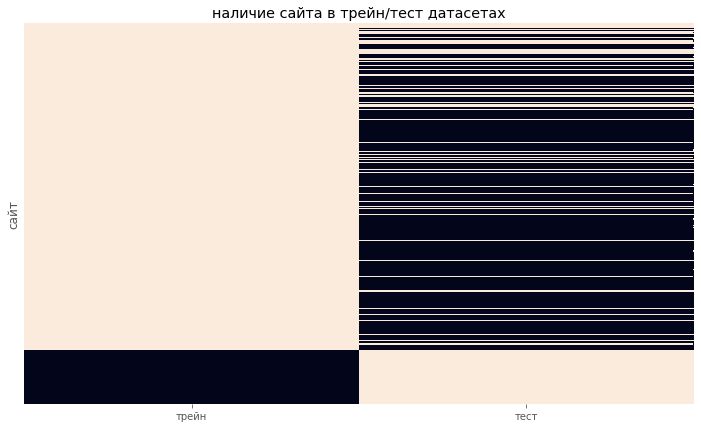

In [7]:
plt.figure(figsize = (12, 7))
sns.heatmap(_sites_report_df, yticklabels=False, cbar=False)
plt.title('наличие сайта в трейн/тест датасетах')
plt.show()

In [8]:
df_flat = pd.Series(df_tr[sites].values.flatten()).to_frame('сайт')
df_flat['дата_посещения'] = pd.Series(df_tr[times].values.flatten())
df_flat['таргет'] = np.repeat(y_tr, 10).values
df_flat = df_flat.dropna(subset = ['сайт']).reset_index(drop = True)

sites_report_df = df_flat.groupby('сайт')['таргет'].agg({'mean', 'count'})\
                                                   .rename(columns = {'mean' : 'доля_Элис',\
                                                                      'count':'всего_посещений'})
sites_report_df['сайт_есть_в_тест_части'] = [idx in unique_sites_te for idx in sites_report_df.index]
sites_report_df = sites_report_df.join(df_flat.groupby('сайт')['дата_посещения'].agg({'min', 'max'})\
                                              .rename(columns = {'min':'первое_посещение',\
                                                                 'max':'последнее_посещение'}))
sites_report_df['дней_между_первым_последним'] = ((sites_report_df['последнее_посещение']\
                                                   - sites_report_df['первое_посещение']) / np.timedelta64(1, 'D')).round()

* отберем сайты, которые были посещены Элис хотя бы раз
* которые посещались хотя бы 10 раз
* последнее посещение в 2014 году
* сайт присутствует в тест части

In [9]:
sample_df = sites_report_df[(sites_report_df['всего_посещений'] >= 10) &\
                            (sites_report_df['сайт_есть_в_тест_части']) &\
                            (sites_report_df['последнее_посещение'].dt.year == 2014) &\
                            (sites_report_df['доля_Элис']>y_tr.mean())].sort_values('доля_Элис', ascending = False)

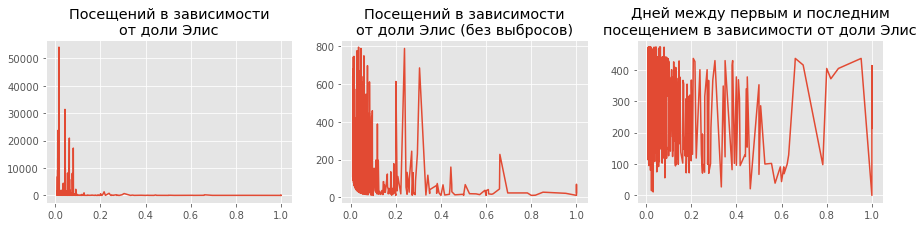

In [10]:
plt.figure(figsize = (15, 3))
plt.subplot(1, 3, 1)
plt.plot(sample_df['доля_Элис'].values, sample_df['всего_посещений'].values)
plt.title('Посещений в зависимости\nот доли Элис')

total = sample_df['всего_посещений']
q25, q75 = total.quantile([.25, .75])
iqr = q75-q25
outlier_mask = total.between(q25-1.5*iqr, q75+1.5*iqr)

plt.subplot(1, 3, 2)
plt.plot(sample_df[outlier_mask]['доля_Элис'].values, sample_df[outlier_mask]['всего_посещений'].values)
plt.title('Посещений в зависимости\nот доли Элис (без выбросов)')

plt.subplot(1, 3, 3)
plt.plot(sample_df['доля_Элис'].values, sample_df['дней_между_первым_последним'].values)
plt.title('Дней между первым и последним\nпосещением в зависимости от доли Элис')
plt.show()

### время

In [11]:
date_tr = df_tr['time1'].dt.round('H')
date_te = df_te['time1'].dt.round('H')

df_tr['день_года'] = date_tr.dt.dayofyear
df_tr['неделя_года'] =date_tr.dt.weekofyear
df_tr['год'] =date_tr.dt.year
df_tr['месяц'] =date_tr.dt.month
df_tr['день'] =date_tr.dt.day
df_tr['день_недели'] =date_tr.dt.dayofweek
df_tr['час'] =date_tr.dt.hour

df_te['день_года'] = date_te.dt.dayofyear
df_te['неделя_года'] =date_te.dt.weekofyear
df_te['год'] =date_te.dt.year
df_te['месяц'] =date_te.dt.month
df_te['день'] =date_te.dt.day
df_te['день_недели'] =date_te.dt.dayofweek
df_te['час'] =date_te.dt.hour

ts_cols = ['день_года', 'неделя_года', 'год', 'месяц', 'день', 'день_недели', 'час']

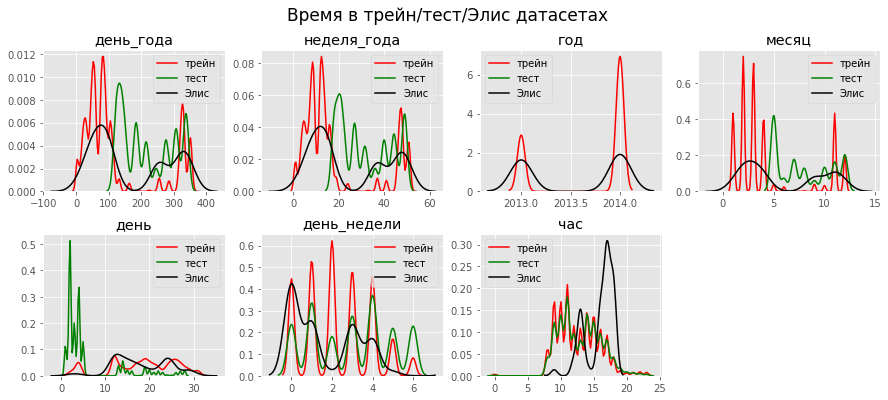

In [12]:
plt.figure(figsize = (15, 6))
plt.suptitle('Время в трейн/тест/Элис датасетах', fontsize = 17)
for i, col in enumerate(ts_cols):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(df_tr[col], label = 'трейн', color = 'red')
    sns.kdeplot(df_te[col], label = 'тест', color = 'green')
    sns.kdeplot(df_tr[col][y_tr==1], label = 'Элис', color = 'black')
    plt.title(col)
plt.subplots_adjust(hspace = .3)

### оставляем в трейне сайты из тест части

### кодируем сайты с помощью tfidf (последовательности из 1, 2, 3 сайтов)

* tfidf(википедия) - статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса.Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

In [14]:
sites_to_use = np.intersect1d(pd.Series(df_tr[y_tr==1][sites].values.flatten()).dropna().unique(),\
                              pd.Series(df_te[sites].values.flatten()).dropna().unique())
sites_tr = df_tr[sites].applymap(lambda x: x if x in sites_to_use else -1)
sites_str_full = pd.DataFrame(np.r_[sites_tr, df_te[sites].fillna(-1)])\
                   .astype(str).apply(lambda row:'_'.join(row), axis = 1)
vec = TfidfVectorizer(ngram_range = (1, 2))
tfidf_full = csc_matrix(vec.fit_transform(sites_str_full))
tfidf_tr, tfidf_te = tfidf_full[:len(y_tr)], tfidf_full[len(y_tr):]

In [21]:
ts_fs_tr, ts_fs_te = [], []
for col in ts_cols:
    to_use = np.unique(df_te[col])
    ts_fs_tr.append(df_tr[col].apply(lambda x: x if x in to_use else -1))
    ts_fs_te.append(df_te[col].fillna(-1))
ohe_tr = pd.get_dummies(df_tr[ts_cols].fillna(-1), columns = ts_cols, drop_first = True)
ohe_te = pd.get_dummies(df_te[ts_cols].fillna(-1), columns = ts_cols, drop_first = True)
to_use = set.intersection(set(ohe_tr.columns), set(ohe_te.columns))
ohe_tr = ohe_tr[to_use]
ohe_te = ohe_te[to_use]

In [55]:
logit_est = LogisticRegression(random_state = SEED)
lgb_est = LGBMClassifier(random_state = SEED)

### выбираем схему валидации с минимальным разбросом метрики по фолдам

In [56]:
# инициализируем размах валидации
range_cv_best = np.inf

# доли отложенной части
for share in tqdm_notebook([.1, .2, .3]):
    # число фолдов
    for nfolds in tqdm_notebook([3, 5, 7, 9]):
        mean_cv, holdout, range_cv =\
            _get_val_holdout_scores(logit_est, _X_tr, _y_tr,\
                                    holdout_share=share, cv=TimeSeriesSplit(nfolds),\
                                    metric='roc_auc', stratify=False)
        # находим параметры для минимального размаха метрики
        if range_cv<range_cv_best:
            range_cv_best = range_cv
            CV_BEST = TimeSeriesSplit(np.int32(nfolds))
            HOLDOUT_SHARE_BEST = share

In [59]:
print('лучшая схема валидации: {}\nлучшая доля отложенной выборки: {}'.format(CV_BEST, HOLDOUT_SHARE_BEST))

лучшая схема валидации: TimeSeriesSplit(max_train_size=None, n_splits=3)
лучшая доля отложенной выборки: 0.2


In [82]:
# параметры для отбора признаков
logit_selector = FEATURE_SELECTOR(estimator = logit_est,
                                  cv = CV_BEST,\
                                  scoring = 'roc_auc',\
                                  holdout_share = HOLDOUT_SHARE_BEST,\
                                  stratify = False,\
                                  seed = SEED)

# валидация каждого признака
cv_scores = logit_selector.fit(_X_tr, _y_tr)

# жадное добавление с ранней остановкой
best_cv, best_holdout, best_features = logit_selector.select_features(early_stopping=20)

In [ ]:
print('лучший auc на валидации = {}\nлучший auc на отложенной = {}'\
      .format(best_cv, best_holdout))

In [ ]:
_X_best_tr, _X_best_te = _X_tr[:, best_features], _X_te[:, best_features]


### оптимизация гиперпараметров

In [ ]:
C_grid = {'C' : np.logspace(-1, 2, 100)}

logit_grid = GridSearcvCV(logit_est, param_grid = C_grid, scoring = 'roc_auc', cv = CV_BEST)
logit_grid.fit(_X_best_tr, _y_tr)

print('auc после оптимизации логистической регрессии = {}'.format(logit_grid.best_params_))
print('оптимальные параметры = {}'.format(logit_grid.best_params_))

### стекинг

In [ ]:
best_score, X_best_tr, X_best_te = \
    _do_stacking(_X_best_tr, y_tr, _X_best_te,\
                 stratify = False,\
                 holdout_share = HOLDOUT_SHARE_BEST,\
                 seed = SEED, n_iterations = 50)

In [21]:
# лучший auc на валидации (logit) = 0.9829279828631695
# лучший auc на отложенной (logit) = 0.9820861328797534

# [0,
#  1,
#  39106,
#  39107,
#  80439,
#  26768,
#  27003,
#  27813,
#  80440,
#  80425,
#  80394,
#  80399,
#  80433,
#  80432,
#  80431,
#  80435,
#  9654,
#  80437,
#  80438,
#  12462,
#  80401,
#  26977,
#  80421,
#  225,
#  16442,
#  80406,
#  6026,
#  27385,
#  13716,
#  80410,
#  80416,
#  80428,
#  25732,
#  80430,
#  26983,
#  1071,
#  18509,
#  80434,
#  27953,
#  7766,
#  12463,
#  476,
#  6027,
#  80426,
#  2102,
#  80429,
#  7713,
#  80424,
#  151,
#  80411,
#  80415,
#  8104,
#  27463,
#  80423,
#  28820,
#  27168,
#  24533,
#  80413,
#  26974,
#  28169,
#  7819,
#  28058,
#  24797,
#  24603,
#  26473,
#  28067,
#  26470,
#  6552,
#  80405,
#  8842,
#  23770,
#  29557,
#  6466,
#  10053,
#  17864,
#  6661,
#  6730,
#  9400,
#  7872,
#  41176,
#  26996,
#  21239,
#  27480,
#  24232,
#  80395,
#  9799,
#  27196,
#  1124,
#  393,
#  17346,
#  13156,
#  13157,
#  7726,
#  6133,
#  4654,
#  21968,
#  27197,
#  12722,
#  15868,
#  80400,
#  27189,
#  80418,
#  316,
#  21436,
#  24604,
#  545,
#  621,
#  21487,
#  3367,
#  27141,
#  26466,
#  49093,
#  27474,
#  23747,
#  20097,
#  29231,
#  12731,
#  25786,
#  20075,
#  4646,
#  20726,
#  12193,
#  13194,
#  27155,
#  21486,
#  28209,
#  23694,
#  41,
#  28068,
#  25789,
#  26929,
#  85,
#  80420,
#  77491,
#  80441,
#  3271,
#  9430,
#  18196,
#  1704,
#  21324,
#  17412,
#  27816,
#  25927,
#  19289,
#  49512,
#  77415,
#  27878,
#  16060,
#  25686,
#  27011,
#  20117,
#  67016,
#  16751,
#  26952,
#  80444,
#  21910,
#  26374,
#  18604,
#  7727,
#  13482,
#  19619,
#  39233,
#  4617,
#  25527,
#  13323,
#  11998,
#  6389,
#  8409,
#  78797,
#  25160,
#  24503,
#  25641,
#  80445,
#  16917,
#  567,
#  547,
#  40989,
#  318,
#  3830,
#  80443,
#  8954,
#  4306,
#  2686,
#  75324,
#  12002,
#  11954,
#  86,
#  36565,
#  23073,
#  21050,
#  24415,
#  41177,
#  29454,
#  11546,
#  6678,
#  80442,
#  75353,
#  26483,
#  3368,
#  11622,
#  25853,
#  26587,
#  12532,
#  11979,
#  27476,
#  5067,
#  24153,
#  78736,
#  39416,
#  9532,
#  639,
#  36666,
#  27924,
#  24233,
#  10003,
#  80392,
#  24575,
#  19414,
#  687,
#  18601,
#  41666,
#  29371,
#  54036,
#  18223,
#  19633,
#  87,
#  19770,
#  223,
#  16950,
#  21334,
#  23937,
#  47304,
#  18249,
#  24296,
#  12123,
#  12151,
#  18195,
#  1705,
#  23280,
#  22028,
#  1417,
#  9484,
#  79029,
#  47317,
#  29466,
#  15934,
#  10708,
#  16175,
#  63510,
#  16340,
#  5645,
#  10064,
#  210,
#  6810,
#  9095,
#  7137,
#  41897,
#  18,
#  6019,
#  67384,
#  7790,
#  18341,
#  11812,
#  22602,
#  27727,
#  6973,
#  25183,
#  8831,
#  4692,
#  436,
#  8522,
#  45899,
#  6869,
#  586,
#  7725,
#  6868,
#  1643,
#  26102,
#  20278,
#  4510,
#  9733,
#  23664,
#  25464,
#  28895,
#  78816,
#  49637,
#  267,
#  22769,
#  14812,
#  649,
#  164,
#  6125,
#  2208,
#  14015,
#  76340,
#  12000,
#  6390,
#  28791,
#  15895,
#  20147,
#  28177,
#  6629,
#  48889,
#  110,
#  28005,
#  77536,
#  13917,
#  6341,
#  71404,
#  619,
#  16176,
#  41898,
#  12656,
#  29027,
#  24528,
#  13897,
#  37840,
#  52714,
#  29,
#  370,
#  7471,
#  371,
#  29298,
#  14016,
#  27187,
#  2131,
#  28828,
#  9090,
#  23771,
#  17671,
#  640,
#  24534,
#  20892,
#  13755,
#  9962,
#  24798,
#  5712,
#  45885,
#  24828,
#  23705,
#  368,
#  11551,
#  30,
#  19415,
#  24731,
#  2544,
#  28045,
#  176,
#  615,
#  1550,
#  6731,
#  626,
#  11114,
#  7699,
#  47349,
#  2014,
#  2760,
#  23199,
#  8145,
#  6496,
#  28885,
#  80396,
#  36656,
#  564,
#  10382,
#  467,
#  78754,
#  4619,
#  51932,
#  8523,
#  148,
#  28442,
#  560,
#  9806,
#  43596,
#  75432,
#  29457,
#  10788,
#  7677,
#  8385,
#  6662,
#  21051,
#  5847,
#  45992,
#  10020,
#  334,
#  9959,
#  57366,
#  13736,
#  2168,
#  13164,
#  566,
#  345,
#  77881,
#  6468,
#  2442,
#  27437]

[0,
 1,
 39106,
 39107,
 80439,
 26768,
 27003,
 27813,
 80440,
 80425,
 80394,
 80399,
 80433,
 80432,
 80431,
 80435,
 9654,
 80437,
 80438,
 12462,
 80401,
 26977,
 80421,
 225,
 16442,
 80406,
 6026,
 27385,
 13716,
 80410,
 80416,
 80428,
 25732,
 80430,
 26983,
 1071,
 18509,
 80434,
 27953,
 7766,
 12463,
 476,
 6027,
 80426,
 2102,
 80429,
 7713,
 80424,
 151,
 80411,
 80415,
 8104,
 27463,
 80423,
 28820,
 27168,
 24533,
 80413,
 26974,
 28169,
 7819,
 28058,
 24797,
 24603,
 26473,
 28067,
 26470,
 6552,
 80405,
 8842,
 23770,
 29557,
 6466,
 10053,
 17864,
 6661,
 6730,
 9400,
 7872,
 41176,
 26996,
 21239,
 27480,
 24232,
 80395,
 9799,
 27196,
 1124,
 393,
 17346,
 13156,
 13157,
 7726,
 6133,
 4654,
 21968,
 27197,
 12722,
 15868,
 80400,
 27189,
 80418,
 316,
 21436,
 24604,
 545,
 621,
 21487,
 3367,
 27141,
 26466,
 49093,
 27474,
 23747,
 20097,
 29231,
 12731,
 25786,
 20075,
 4646,
 20726,
 12193,
 13194,
 27155,
 21486,
 28209,
 23694,
 41,
 28068,
 25789,
 26929,
